In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd
import seaborn as sns
import time

## Load pretrained model from Task 1

In [78]:
#This cell is for the user who are using pre-trained model. If you have run the training loop above and model is already trained, you can skip
pretrained_model = resnet18(weights=None)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.004083)

In [80]:
state_dict = torch.load('resnet18_model_98.pth', map_location=torch.device('cpu'))
pretrained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [81]:
# Remove the last classifier layer
pretrained_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-1]))

## Load a ResNet18 model with ImageNet weights

In [37]:
imagenet_model = resnet18(weights='IMAGENET1K_V1')
num_features = imagenet_model.fc.in_features
imagenet_model.fc = nn.Linear(num_features, 3)
# Remove the final classification layer to use the model as a feature extractor
imagenet_model = nn.Sequential(*(list(imagenet_model.children())[:-1]))

## Prepare datasets

In [69]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset1 = datasets.ImageFolder('Colorectal Cancer', transform=transform)
dataset2 = datasets.ImageFolder('Prostate Cancer', transform=transform)
dataset3 = datasets.ImageFolder('Animal Faces', transform=transform)

# Data loader
data_loader_1 = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=False)
data_loader_2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)
data_loader_3 = torch.utils.data.DataLoader(dataset3, batch_size=64, shuffle=False)

## Function to extract features

In [48]:
import torch
import numpy as np

def extract_features_and_labels(model, data_loader, device):
    model.eval()
    extracted_features = []
    y_tsne = []

    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            images = images.to(device)

            # Remove the last classification layer and extract features
            features = model(images)
            features = features.view(features.size(0), -1)

            extracted_features.append(features.cpu().numpy())
            y_tsne.append(labels.numpy())  # Assuming the labels are not already on the CPU

    # Concatenate all features and labels to get the full set
    extracted_features = np.concatenate(extracted_features, axis=0)
    y_tsne = np.concatenate(y_tsne, axis=0)

    return extracted_features, y_tsne

##  Extract Dataset 1 to test

In [53]:
dataset1_features, dataset1_labels = extract_features_and_labels(pretrained_model, data_loader_1, device='cpu')
dataset1_features = np.array(dataset1_features)
dataset1_labels = np.array(dataset1_labels)

In [54]:
# Check to see if the np array has a shpae of (6000, 512)
print(dataset1_features.shape)
print(dataset1_labels.shape)

(6000, 512)
(6000,)


## Extract Datasets 2 and 3 on Task 1 model

In [82]:
dataset2_features_task1, dataset2_labels_task1 = extract_features_and_labels(pretrained_model, data_loader_2, device='cpu')
dataset3_features_task1, dataset3_labels_task1 = extract_features_and_labels(pretrained_model, data_loader_3,  device='cpu')

In [83]:
dataset2_features_task1 = np.array(dataset2_features_task1)
dataset3_features_task1 = np.array(dataset3_features_task1)
print(dataset2_features_task1.shape)
print(dataset3_features_task1.shape)

(6000, 512)
(6000, 512)


In [58]:
import numpy as np
import pandas as pd

def save_dataset_to_csv(features, labels, title):
    df = pd.DataFrame(features)
    df['label'] = labels  # Add labels as a new column

    # Save to CSV
    df.to_csv(f'{title}.csv', index=False)

In [84]:
save_dataset_to_csv(dataset2_features_task1, dataset2_labels_task1, "Dataset2_task1model")
save_dataset_to_csv(dataset3_features_task1, dataset3_labels_task1, "Dataset3_task1model")

## Extract Datasets 2 and 3 on model with ImageNet weights

In [73]:
dataset2_features_imgn, dataset2_labels_imgn = extract_features_and_labels(imagenet_model, data_loader_2, device='cpu')
dataset3_features_imgn, dataset3_labels_imgn = extract_features_and_labels(imagenet_model, data_loader_3,  device='cpu')

In [74]:
dataset2_features_imgn = np.array(dataset2_features_imgn)
dataset3_features_imgn = np.array(dataset3_features_imgn)
print(dataset2_features_imgn.shape)
print(dataset3_features_imgn.shape)

(6000, 512)
(6000, 512)


In [75]:
save_dataset_to_csv(dataset2_features_imgn, dataset2_labels_imgn, "Dataset2_imagenet")
save_dataset_to_csv(dataset3_features_imgn, dataset3_labels_imgn, "Dataset3_imagenet")

## Visualize the new sets with t-SNE

In [76]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def tsne_visualization_with_labels(features, labels, title):
    # Apply t-SNE to reduce the features to 2D
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    # Plotting with color-coding for labels
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Select indices of data points with the current label
        indices = labels == label
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label, alpha=0.5)

    plt.title(f't-SNE Visualization of {title}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Labels')
    plt.show()

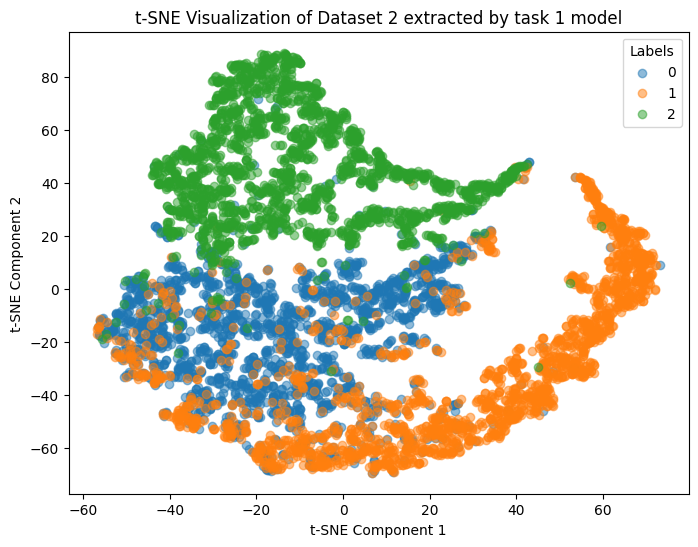

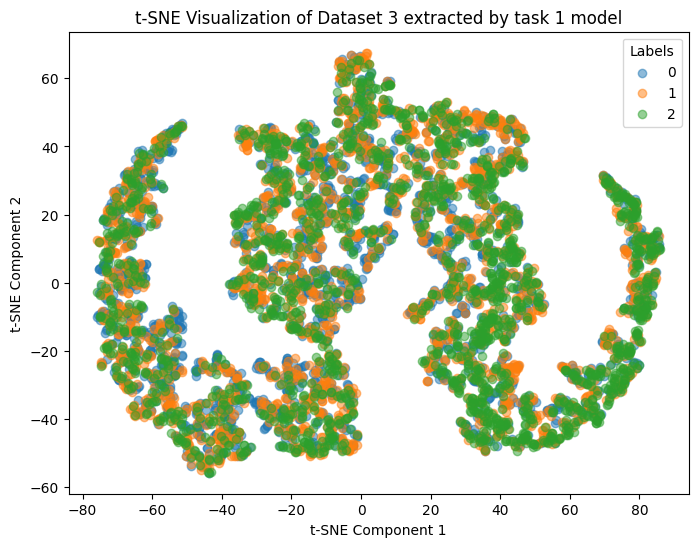

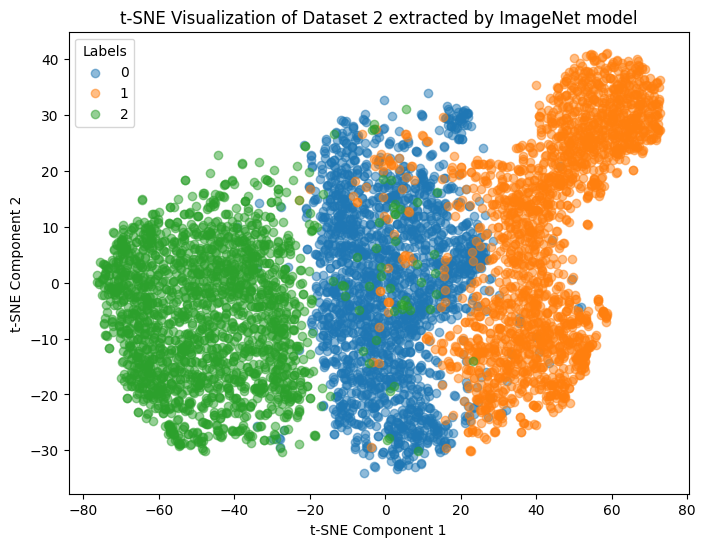

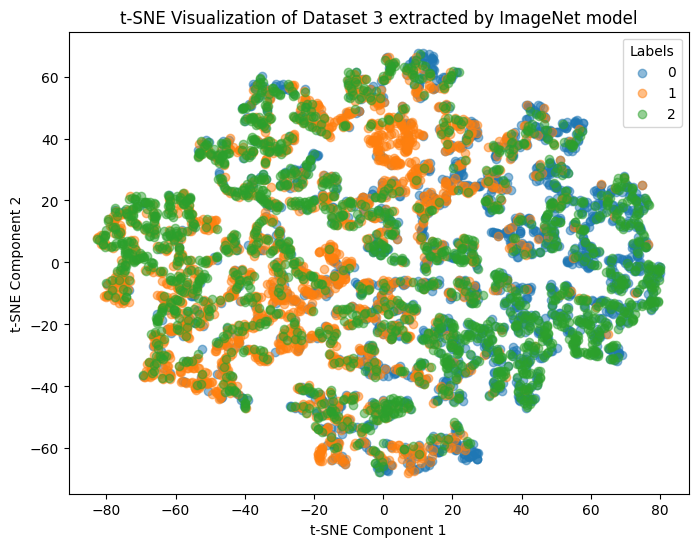

In [85]:
# Visualize each dataset
tsne_visualization_with_labels(dataset2_features_task1, dataset2_labels_task1, "Dataset 2 extracted by task 1 model")
tsne_visualization_with_labels(dataset3_features_task1, dataset3_labels_task1, "Dataset 3 extracted by task 1 model")
tsne_visualization_with_labels(dataset2_features_imgn, dataset2_labels_imgn, "Dataset 2 extracted by ImageNet model" )
tsne_visualization_with_labels(dataset3_features_igmn, dataset3_labels_imgn, "Dataset 3 extracted by ImageNet model")